# <span><h1 style = "font-family: garamond; font-size: 38px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center"> Anomaly Detection for Quality Control🔎⚙️</h1></span>

### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center">Import Required Libraries</h1></span>

In [ ]:
import os
import copy
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage.metrics import structural_similarity as ski_ssim
from tqdm.auto import tqdm
from typing import Dict, Optional, Callable

import torch
from pytorch_msssim import SSIM
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from torchvision import transforms

# Setup device to GPU if possible
device = "cuda" if torch.cuda.is_available() else "cpu"
device

### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center"> Parameters</h1></span>

In [ ]:
SEED = 42
DATASET = 'capsule'         # Selected dataset from "data/" directory
NUM_WORKERS = os.cpu_count()
IMG_RESIZE = 256            # Resize of an input images
INPUT_CROP  = 256           # Crop of resized images (when equal to IMG_RESIZE value, there is no crop applied)
TRAINING_SIZE = 1000        # Number of images used for training
TEST_SIZE = 100             # Number of images used for testing

NUM_EPOCHS = 200
BATCH_SIZE = 32
BASE_LEARNING_RATE = 1e-2
SCH_PATIENCE = 10
SCH_FACTOR = 0.5

In [ ]:
train_dir = Path(f"data/{DATASET}/train")
test_dir = Path(f"data/{DATASET}/test")

### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center">Set seed for reproducibility</h1></span>

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # If running on the CuDNN backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center">View subdirectories</h1></span>

In [5]:
def explore_dir(dir_path: Path) -> None:
    """
    Function for exploring specified directory dependencies and number of images
    
    Args:
        dir_path (str or Path): Location of interested directory   
    """
    for current_dir, dirs, img in os.walk(dir_path):
        print(f"'{current_dir}' have {len(dirs)} directories and {len(img)} images.")
    print("")

explore_dir(train_dir)
explore_dir(test_dir)

'data\capsule\train' have 1 directories and 0 images.
'data\capsule\train\good' have 0 directories and 219 images.

'data\capsule\test' have 6 directories and 0 images.
'data\capsule\test\crack' have 0 directories and 23 images.
'data\capsule\test\faulty_imprint' have 0 directories and 22 images.
'data\capsule\test\good' have 0 directories and 23 images.
'data\capsule\test\poke' have 0 directories and 21 images.
'data\capsule\test\scratch' have 0 directories and 23 images.
'data\capsule\test\squeeze' have 0 directories and 20 images.



### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center">Visualize data</h1></span>

Random image path: data\capsule\test\good\004.png
Image size: 1000x1000


(-0.5, 999.5, 999.5, -0.5)

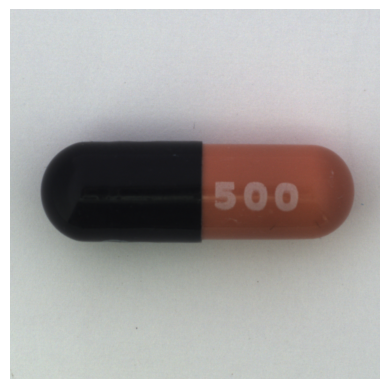

In [6]:
images_paths = list(test_dir.glob("*/*.png"))
random_image_path = random.choice(images_paths)
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image size: {img.height}x{img.width}") 

plt.imshow(img)
plt.axis("off")

### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center">Data augmentation</h1></span>

In [7]:
data_transform = transforms.Compose([
    transforms.Resize(size=(IMG_RESIZE, IMG_RESIZE)),
    transforms.Grayscale(1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()])

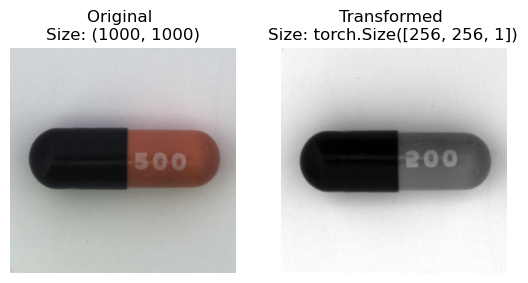

In [8]:
def image_transformation_plot(image_path: str, transform: transforms.Compose) -> None:
    """
    Plots and compares selected image before and after transformation.
    
    Args:
        image_path (Path): Path of image to plot
        transform (Pytorch Transforms): Selected transforms composition
    """
    f = Image.open(image_path)
    
    fig, ax = plt.subplots(1, 2)
    plt.gray()
    ax[0].imshow(f) 
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")
    
    transformed_image = transform(f).permute(1, 2, 0) 
    ax[1].imshow(transformed_image) 
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

image_transformation_plot(random_image_path, data_transform)

### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center">Train and test datasets preparation</h1></span> 

Custom train/test dataset preparation function have been written to control datasets size and enable pictures crop.

In [9]:
def random_crop(data_dir: Path, N: int, crop: int) -> TensorDataset:
    """
    Function for building a dataset with randomly chosen images with applied random crops to size.
    
    Args:
        data_dir (str or Path): Location of the directory containing images.
        N (int): Number of images in the prepared dataset.
        crop (int): Size of the crop (crop, crop).
        
    Returns:
        output_dataset (list): A list of cropped images
    """

    crop_size = (crop, crop)
    output_dataset = []
    images_paths = list(data_dir.glob("good/*.png"))

    if not images_paths:
        raise ValueError(f"No images found in directory: {data_dir}/good")

    if crop > IMG_RESIZE:
        raise ValueError(f"Crop size {crop} is larger than desired image size {IMG_RESIZE}.")
  
    for i in range(0, N):
        random_image_path = random.choice(images_paths)
        img = Image.open(random_image_path)
        img = data_transform(img).squeeze(0)
        
        x_start = random.randint(0, img.shape[0]-crop_size[0])
        y_start = random.randint(0, img.shape[1]-crop_size[1])
        x_end = x_start + crop_size[0]
        y_end = y_start + crop_size[1]
        
        crop = img[x_start:x_end, y_start:y_end]
        crop = crop.type(torch.float32).unsqueeze(0)
        output_dataset.append(crop)

    return TensorDataset(torch.stack(output_dataset))

In [10]:
train_data = random_crop(data_dir=train_dir, N=TRAINING_SIZE, crop = INPUT_CROP)
test_data = random_crop(data_dir=test_dir, N=TEST_SIZE, crop = INPUT_CROP)

print(f"Image tensor:\n{test_data[0][0]}")
print(f"Image shape: {test_data[0][0].shape}")
print(f"Image datatype: {test_data[0][0].dtype}")

Image tensor:
tensor([[0.8745, 0.8824, 0.8824,  ..., 0.8706, 0.8706, 0.8667],
        [0.8824, 0.8784, 0.8784,  ..., 0.8745, 0.8706, 0.8667],
        [0.8863, 0.8745, 0.8745,  ..., 0.8706, 0.8667, 0.8667],
        ...,
        [0.8667, 0.8588, 0.8549,  ..., 0.8235, 0.8275, 0.8235],
        [0.8588, 0.8627, 0.8549,  ..., 0.8275, 0.8275, 0.8275],
        [0.8549, 0.8627, 0.8588,  ..., 0.8314, 0.8275, 0.8275]])
Image shape: torch.Size([256, 256])
Image datatype: torch.float32


### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center">Dataloader</h1></span>

In [11]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

# Check if the input values are in <0,1> range to define activation function or normalize
images = next(iter(train_dataloader))
print(f"Image shape: {images.shape}\n {torch.min(images)}\n {torch.max(images)}")

Image shape: torch.Size([32, 1, 256, 256])
 0.0470588244497776
 0.9686274528503418


### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center">Model</h1></span>

In [ ]:
class autoencoder_v0(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 128, 500, 3, stride=1, padding=0)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(500, 128, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 32, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
     
model = autoencoder_v0()

summary(model, input_size=[BATCH_SIZE, 1, INPUT_CROP, INPUT_CROP])

### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center">Train loop</h1></span>

In [13]:
def train_step(model: nn.Module, 
               dataloader: DataLoader, 
               loss_fn: SSIM, 
               optimizer) -> float:
    
    model.train()
    train_loss = 0
        
    for batch, img in enumerate(dataloader):
        
        img = img.to(device)
        recon = model(img)
        loss = 1 - loss_fn(recon, img)
        train_loss += loss.item() 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = train_loss / len(dataloader)
    
    return train_loss

In [14]:
def test_step(model: nn.Module, 
              dataloader: DataLoader, 
              loss_fn: SSIM, 
              epoch: int) -> float:
    
    model.eval()
    test_loss = 0
    
    with torch.inference_mode():
        for batch, img in enumerate(dataloader):

            img = img.to(device)
            recon = model(img)
            loss = 1 - loss_fn(recon, img)
            test_loss += loss.item() 
    
        test_loss = test_loss / len(dataloader)
    
    return test_loss

In [15]:
def train(model: nn.Module, 
          train_dataloader: DataLoader, 
          test_dataloader: DataLoader, 
          optimizer, 
          loss_fn: SSIM, 
          epochs: int) -> Dict[str, list]:
    """
    Running train and test steps, plotting training progress and loss values.
    
    Args:
        model: Autoencoder model instance
        train_dataloader: Dataloader with training images
        test_dataloader: Dataloader with test images
        optimizer: Used optimizer - SSIM or MSE
        loss_fn: Used loss function
        epochs: Number of epochs to train the model
        
    Returns:
        results (dict): A dictionary with calculated loss values
    """
    results = {"train_loss": [], "test_loss": []}
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=SCH_PATIENCE, factor=SCH_FACTOR)
    best_weights = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer)
        
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              epoch=epoch)
        
        # Update learning rate if needed
        scheduler.step(test_loss)
        if test_loss < best_loss:
            best_loss = test_loss
            best_weights = copy.deepcopy(model.state_dict())

        train_ssim = (1 - train_loss)*100
        test_ssim = (1 - test_loss)*100
        
        if epoch % 10 == 0:
            print(f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"train_ssim: {train_ssim:.2f}% | "
                f"test_ssim: {test_ssim:.2f}% | ")

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    model.load_state_dict(best_weights)

    return results

### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center">Training the model</h1></span>

SSIM or MSE loss functions can be set up, however better results are achieved by using SSIM, which have higher capability of capturing interdependencies between local image regions. Adam optimizer with 1e-3 learning rate is used.

In [16]:
criterion = SSIM(win_sigma=1.5, data_range=1, size_average=True, channel=1)
optimizer = torch.optim.Adam(params=model.parameters(), lr=BASE_LEARNING_RATE)

In [ ]:
model_results = train(model=model, 
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=criterion, 
                      epochs=NUM_EPOCHS)

Text(0, 0.5, 'Loss')

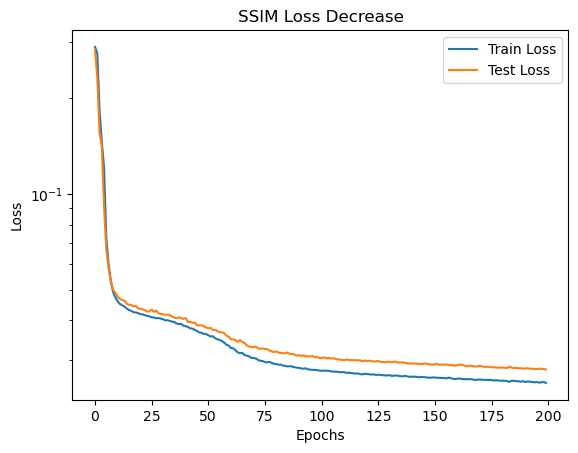

In [17]:
ax = pd.DataFrame({
    'Train Loss': [loss for loss in model_results['train_loss']],
    'Test Loss': [loss for loss in model_results['test_loss']]
}).plot(title='SSIM Loss Decrease', logy=True)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center">Show Anomalies on Test Data</h1></span>

In [18]:
def load_model(model_name: str):
    """
    Function for loading saved models parameters.
    
    Args:
        model_name (str): Name of the model to load
        
    Returns:
        loaded_model: A model instance with loaded parameters
    """
    model_path = Path("models")
    model_save_path = model_path / model_name

    loaded_model = autoencoder_v0()
    loaded_model.load_state_dict(torch.load(f=model_save_path))

    loaded_model = loaded_model.to(device)
    
    return loaded_model
    
MODEL_NAME = "grid_500x3x3_bottleneck_96acc.pth"
model_loaded = load_model(MODEL_NAME)

In [20]:
# Data transform block to fit input image if the training was done on cropped images.
data_transform_test = transforms.Compose([
    transforms.Resize(size=(INPUT_CROP, INPUT_CROP)),
    transforms.Grayscale(1),
    transforms.ToTensor()
])

In [21]:
def visualize_ssim(model: torch.nn.Module, 
                    image_path: str,  
                    transform: Optional[Callable] = None,
                    device: torch.device = device) -> None:
    
    """ Plots the original image, the reconstructed image, and the SSIM contour.

    Args:
        model (torch.nn.Module): The autoencoder model.
        image_path (str): Path to the image file.
        transform (Optional[Callable]): Optional transformation to apply to the image before reconstruction.
        device (torch.device): Device on which to run the model (CPU or GPU).

    Returns:
        None
    """

    img = Image.open(image_path)
    
    if transform:
        img_transformed = transform(img)
    else:
        img_transformed = img

    model.to(device)
    model.eval()

    with torch.inference_mode():
        input_image = img_transformed.unsqueeze(dim=0).to(device)
        reconstructed = model(input_image)
    
    original = img_transformed.permute(1, 2, 0).cpu()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).cpu()    

    fig, ax = plt.subplots(1, 3)
    plt.gray()  

    ax[0].imshow(original) 
    ax[0].set_title(f"{image_path.split("/")[3].capitalize()}")
    ax[0].axis("off")
    
    ax[1].imshow(reconstructed) 
    ax[1].set_title("Reconstructed")
    ax[1].axis("off")
    
    img_old = np.array(original.squeeze(2))
    img_new = np.array(reconstructed.squeeze(2))
    
    pixel_range = max(np.max(img_new), np.max(img_old)) - min(np.min(img_new), np.min(img_old))
    _, S = ski_ssim(img_old, img_new, full=True, channel_axis=False, data_range=1) # data range set to 1 or pixel_range, depending on desired precision

    ax[2].imshow(1-S, vmax = 1, cmap='jet') 
    ax[2].set_title("SSIM")
    ax[2].axis("off")

    plt.axis(False)

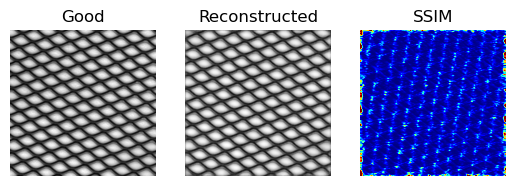

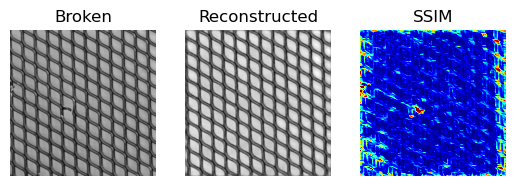

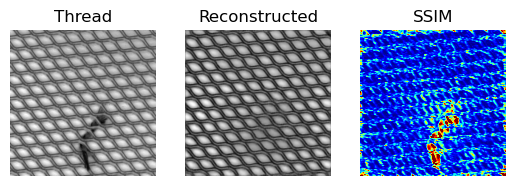

In [21]:
train_image_path = ("data/grid/train/good/019.png")
test_image_path_1 = ("data/grid/test/broken/002.png")
test_image_path_2 = ("data/grid/test/thread/005.png")

visualize_ssim(model=model_loaded,
                        image_path=train_image_path,
                        transform=data_transform,
                        device=device)

visualize_ssim(model=model_loaded,
                        image_path=test_image_path_1,
                        transform=data_transform,
                        device=device)

visualize_ssim(model=model_loaded,
                        image_path=test_image_path_2,
                        transform=data_transform,
                        device=device)

### <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 3px; background-color: #252e29; color: #1cba56; border-radius: 100px 100px; text-align:center">Save model</h1></span>

In [22]:
model_path = Path("models")
model_name = "capsule_500x6x6_bottleneck_97.5acc.pth"
model_save_path = model_path / model_name

print(f"Saving model to: {model_save_path}")

torch.save(obj=model.state_dict(), f=model_save_path)

Saving model to: models\capsule_500x6x6_bottleneck_97.5acc.pth
